### ----------------------------------------------------------------------------------------------------------
## 社会変革型 医療データサイエンティスト育成講座
# Chapter 8: 生存時間分析とCox比例ハザードモデル
### ----------------------------------------------------------------------------------------------------------

In [1]:
# データとライブラリの準備

from lifelines import datasets, KaplanMeierFitter
from lifelines.plotting import plot_lifetimes

# lifelinesに入っているデータセットを使用します
gbsg2_data = datasets.load_gbsg2()
gbsg2_data.head()

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1


## German Breast Cancer Study Group 2
contains the observations of 686 women  
http://ugrad.stat.ubc.ca/R/library/ipred/html/GBSG2.html

| column name | variables |
|:---------|:----------|
| horTh | hormonal therapy, a factor at two levels no and yes |
| age | of the patients in years |
| menostat | menopausal status, a factor at two levels pre (premenopausal) and post (postmenopausal) |
| tsize | tumor size (in mm) |
| tgrade | tumor grade, a ordered factor at levels I < II < III |
| pnodes | number of positive nodes |
| progrec | progesterone receptor (in fmol) |
| estrec | estrogen receptor (in fmol) |
| time | recurrence free survival time (in days) | 
| cens | censoring indicator (0- censored, 1- event) | 

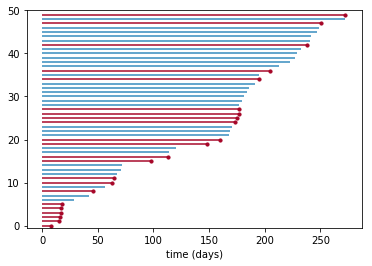

In [2]:
# timeデータの可視化
import matplotlib.pyplot as plt
%matplotlib inline

time = gbsg2_data['time']
event = gbsg2_data['cens']

time_sorted = time.sort_values().values
plot_lifetimes(time_sorted[:50], event_observed=event[:50])
plt.xlabel('time (days)')
plt.show()

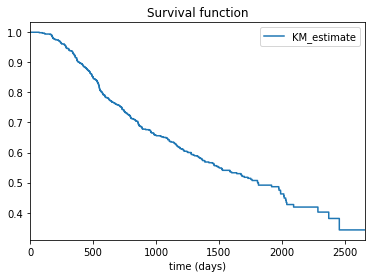

In [3]:
# Kaplan-meier曲線の描画

# sklearnと同じくまずインスタンスの作成
kmf = KaplanMeierFitter()

# 生存時間を表すtimeデータと、
kmf.fit(time, event_observed=event)

kmf.plot(ci_show=False)
plt.title('Survival function')
plt.xlabel('time (days)')
plt.show()

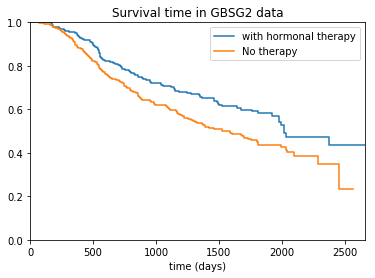

In [4]:
# ホルモン療法の有無で比較

ax = plt.subplot(111)

# ホルモン治療ありの被験者のインデックスを抽出します
therapy = (gbsg2_data["horTh"] == "yes")

# timeデータの中でホルモン治療ありのインデックスを指定します
kmf.fit(time[therapy], event_observed=event[therapy], label="with hormonal therapy")
kmf.plot(ax=ax,ci_show=False)

# ~therapyとすることで、ホルモン治療なしのインデックスを指定します
kmf.fit(time[~therapy], event_observed=event[~therapy], label="No therapy")
kmf.plot(ax=ax,ci_show=False)

plt.ylim(0, 1)
plt.xlabel('time (days)')
plt.title("Survival time in GBSG2 data")
plt.show()

In [5]:
# log-rank検定

from lifelines.statistics import logrank_test

results = logrank_test(time[therapy], time[~therapy], event[therapy], event[~therapy], alpha=.99)
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99

---
 test_statistic      p  -log2(p)
           8.56 <0.005      8.19


Iteration 6: norm_delta = 0.00000, step_size = 1.0000, ll = -1735.73210, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 6 iterations.
<lifelines.CoxPHFitter: fitted with 686 observations, 387 censored>
      duration col = 'time'
         event col = 'cens'
number of subjects = 686
  number of events = 299
partial log-likelihood = -1735.73
  time fit was run = 2019-06-14 13:56:20 UTC

---
              coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
age          -0.01      0.99      0.01 -1.02   0.31      1.69       -0.03        0.01
tsize         0.01      1.01      0.00  1.98   0.05      4.39        0.00        0.02
pnodes        0.05      1.05      0.01  6.55 <0.005     34.03        0.03        0.06
progrec      -0.00      1.00      0.00 -3.87 <0.005     13.14       -0.00       -0.00
estrec        0.00      1.00      0.00  0.44   0.66      0.60       -0.00        0.00
horTh_yes    -0.35      0.71      0.13 -2.68   0.01      7

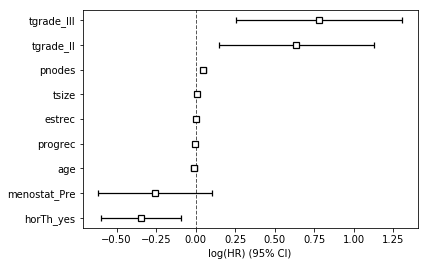

In [6]:
# cox比例ハザードモデル
import pandas as pd
from lifelines import CoxPHFitter

# インスタンスを作成します
cph = CoxPHFitter()

# カテゴリ変数をダミー化します
gbsg2_data_dm = pd.get_dummies(gbsg2_data,columns=['horTh','menostat','tgrade'],drop_first=True)

cph.fit(gbsg2_data_dm, duration_col='time', event_col='cens', show_progress=True)
cph.print_summary()
cph.plot()

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
                   test_statistic    p  -log2(p)
age          km              2.94 0.09      3.53
             rank            2.80 0.09      3.41
estrec       km              1.00 0.32      1.66
             rank            1.41 0.23      2.09
horTh_yes    km  

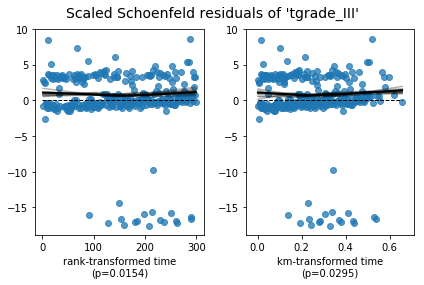

In [7]:
# （参考） Schoenfeld残差を用いた比例ハザード性の検証
cph.check_assumptions(gbsg2_data_dm, p_value_threshold=0.05, show_plots=True)